<a href="https://colab.research.google.com/github/VitoryaBracelos25/Projeto-PNL/blob/main/Projeto_PNL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer   #para pré processamento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

# **Trazendo o dataset**

In [ ]:
# Link direto para o arquivo CSV no GitHub
url = "https://raw.githubusercontent.com/richardcsuwandi/airline-sentiment/master/tweets.csv"  # repositório que achei usando o dataset airline sentiment
df = pd.read_csv(url)
display(df)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,35.888455,-119.273781
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,35.684863,-119.709299
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752
...,...,...,...,...,...,...,...,...,...,...,...,...
14635,5.695877e+17,positive,0.3487,NaN,0.0000,American,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22 12:01:01 -0800,40.747300,-73.972100
14636,5.695874e+17,negative,1.0000,Customer Service Issue,1.0000,American,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22 11:59:46 -0800,40.746100,-73.982100
14637,5.695872e+17,neutral,1.0000,NaN,NaN,American,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22 11:59:15 -0800,40.708800,-73.921000
14638,5.695872e+17,negative,1.0000,Customer Service Issue,0.6659,American,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22 11:59:02 -0800,40.717900,-74.014600


# **Arrumando**

In [ ]:
airline_df= df[['airline_sentiment','airline_sentiment_confidence', 'text', 'airline',]]
airline_df= airline_df[airline_df['airline_sentiment_confidence'] >= 0.7]  #Pra só pegar tweets que sejam acima de 70% confiaveis
airline_df.dropna()
display(airline_df)

,airline_sentiment,airline_sentiment_confidence,text,airline
0,neutral,1.0,@VirginAmerica What @dhepburn said.,Virgin America
3,negative,1.0,@VirginAmerica it's really aggressive to blast...,Virgin America
4,negative,1.0,@VirginAmerica and it's a really big bad thing...,Virgin America
5,negative,1.0,@VirginAmerica seriously would pay $30 a fligh...,Virgin America
9,positive,1.0,"@VirginAmerica it was amazing, and arrived an ...",Virgin America
...,...,...,...,...
14631,negative,1.0,@AmericanAir thx for nothing on getting us out...,American
14633,negative,1.0,@AmericanAir my flight was Cancelled Flightled...,American
14636,negative,1.0,@AmericanAir leaving over 20 minutes Late Flig...,American
14637,neutral,1.0,@AmericanAir Please bring American Airlines to...,American


In [ ]:
airline_df['airline_sentiment'].value_counts()  #tem muito mais sentimento negativo do que positivo e neutro

,count
airline_sentiment,
negative,7552
neutral,1634
positive,1582


In [ ]:
def clean_text(text):
  text= re.sub(r'https?://\S+|www\.\S+', '', text)                #URLs
  text= re.sub(r'[@#]\w+', '', text)                              #Menções e hashtags
  text= re.sub(r'\d+', '', text)                                  #Números
  text= re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text) #Pontuação
  text= re.sub(r'[^\w\s]', '', text)                              #Caracteres especiais e emojis
  return text


X= airline_df["text"]
y= airline_df["airline_sentiment"]
X_clean= X.apply(clean_text)


#vetorizando
vectorizer= TfidfVectorizer(
        lowercase= True,          #deixar tudo minusculo
        stop_words= 'english',    #tirar as preposições
        max_features= 5000,       #Limita o vocabulário às 5000 palavras mais frequentes
        ngram_range= (1, 2))      #palavras com sentido junto "good" "not good"


X_vec= vectorizer.fit_transform(X_clean)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state=42, stratify=y)  #stratify mantém a mesma proporção do treino no teste
print(X_vec.shape)
print(y.shape)
X_vec.nnz / (X_vec.shape[0] * X_vec.shape[1])

(10768, 5000)
(10768,)


0.0016894687964338782

# **Gráfico**

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


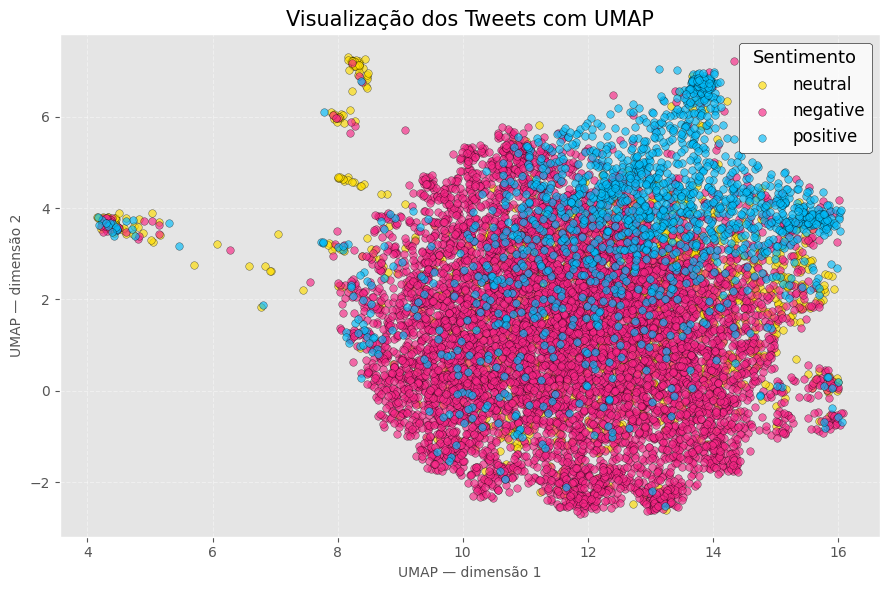

In [ ]:
svd= TruncatedSVD(n_components=50, random_state=42)
X_reduced= svd.fit_transform(X_vec)

umap_model= umap.UMAP(
    n_neighbors=50,
    min_dist=0.5,
    n_components=2,
    metric='correlation',
    random_state=42
)

# X_vec -> matriz TF-IDF/Sparse
umap_embeddings= umap_model.fit_transform(X_vec)

plt.figure(figsize=(9, 6))
plt.style.use("ggplot")

colors = {
    'negative': '#F72585',   # vermelho
    'neutral':  '#FFDD00',   # amarelo
    'positive': '#00BBF9'    # azul
}

for sentiment in y.unique():
    mask = y == sentiment
    plt.scatter(
        umap_embeddings[mask, 0], umap_embeddings[mask, 1],
        c=colors[sentiment],
        s=30,
        alpha=0.65,
        linewidths=0.3,
        edgecolor="black",
        label=sentiment
    )

plt.title("Visualização dos Tweets com UMAP", fontsize=15)
plt.xlabel("UMAP — dimensão 1", fontsize=10)
plt.ylabel("UMAP — dimensão 2", fontsize=10)
plt.legend(
    title="Sentimento",
    fontsize=12,
    title_fontsize=13,
    frameon=True,
    shadow=False,
    facecolor="white",
    edgecolor="black"
    )
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
model= LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_vec, y)

#Pegar nomes das palavras
feature_names= vectorizer.get_feature_names_out()

#Criar DataFrame organizado por classe
coefs = pd.DataFrame(model.coef_,
                     index=model.classes_,
                     columns=feature_names)

#Pegar top palavras por classe (positivas puxadas ↑, negativas puxadas ↓)
top_words= {}
for cls in model.classes_:
    top_words[cls]= coefs.loc[cls].sort_values(ascending=False).head(15)

for cls in model.classes_:
    print(f"\n==== Palavras que mais puxam para classe: {cls.upper()} ====")
    print(top_words[cls])


==== Palavras que mais puxam para classe: NEGATIVE ====
hours        3.894379
worst        3.314566
hour         3.266767
delayed      3.174344
hold         3.114456
hrs          3.085591
cancelled    2.554308
luggage      2.507831
lost         2.322819
customers    2.288604
rude         2.266135
waiting      2.238785
min          2.237542
told         2.214520
stuck        2.211197
Name: negative, dtype: float64

==== Palavras que mais puxam para classe: NEUTRAL ====
hi           2.415655
tomorrow     1.932577
chance       1.827775
brother      1.668824
anytime      1.623364
atlanta      1.578790
flights      1.396278
weekend      1.378882
does         1.378189
bring        1.369449
submitted    1.347341
include      1.325526
low          1.299449
possible     1.297661
penalty      1.294796
Name: neutral, dtype: float64

==== Palavras que mais puxam para classe: POSITIVE ====
thank         5.869011
thanks        5.406857
great         5.225908
awesome       4.317402
love          3.8

# **Funções Kernel**

In [ ]:
SVM_linear= SVC(kernel= 'linear' , C= 1.0, class_weight= 'balanced')
SVM_linear.fit(X_train, y_train)

predict_linear= SVM_linear.predict(X_test)
accuracy_linear= accuracy_score(y_test, predict_linear)
print(f'Acuracia de classificação: {round(accuracy_linear, 4) * 100}% ')

Acuracia de classificação: 81.35% 


In [ ]:
SVM_poly= SVC(kernel= 'poly', degree=3, gamma= 'scale', C= 1.0, coef0= 2, class_weight= 'balanced')
SVM_poly.fit(X_train, y_train)

predict_poly= SVM_poly.predict(X_test)
accuracy_poly= accuracy_score(y_test, predict_poly) #determinar qual foi a acuracia de classificação, quantos objetos classificou certamente
print(f'Acuracia de classificação: {round(accuracy_poly, 4) * 100}% ')

Acuracia de classificação: 83.54% 


In [ ]:
SVM_sigmoid= SVC(kernel= 'sigmoid', gamma= 'scale', C= 1.0, coef0= 2, class_weight= 'balanced')
SVM_sigmoid.fit(X_train, y_train)

predict_sigmoid= SVM_sigmoid.predict(X_test)
accuracy_sigmoid= accuracy_score(y_test, predict_sigmoid)
print(f'Acuracia de classificação: {round(accuracy_sigmoid, 4) * 100}% ')

Acuracia de classificação: 70.88% 


In [ ]:
SVM_rbf= SVC(kernel= 'rbf',gamma= 'scale', C= 1.0, class_weight= 'balanced')
SVM_rbf.fit(X_train, y_train)

predict_rbf= SVM_rbf.predict(X_test)
accuracy_rbf= accuracy_score(y_test, predict_rbf)
print(f'Acuracia de classificação: {round(accuracy_rbf, 4) * 100}% ')

Acuracia de classificação: 85.33% 




---



In [ ]:
SVM_poly_4= SVC(kernel= 'poly', degree=4, gamma= 'scale', C= 1.0, coef0= 2, class_weight= 'balanced')
SVM_poly_4.fit(X_train, y_train)

predict_poly_4= SVM_poly_4.predict(X_test)
accuracy_poly_4= accuracy_score(y_test, predict_poly_4)
print(f'Acuracia de classificação: {round(accuracy_poly_4, 4) * 100}% ')

Acuracia de classificação: 83.62% 


In [ ]:
SVM_poly_7= SVC(kernel= 'poly', degree=7, gamma= 'scale', C= 1.0, coef0= 2, class_weight= 'balanced')
SVM_poly_7.fit(X_train, y_train)

predict_poly_7= SVM_poly_7.predict(X_test)
accuracy_poly_7= accuracy_score(y_test, predict_poly_7)
print(f'Acuracia de classificação: {round(accuracy_poly_7, 4) * 100}% ')

Acuracia de classificação: 83.21% 


In [ ]:
SVM_poly_10= SVC(kernel= 'poly', degree=10, gamma= 'scale', C= 1.0, coef0= 2, class_weight= 'balanced')
SVM_poly_10.fit(X_train, y_train)

predict_poly_10= SVM_poly_10.predict(X_test)
accuracy_poly_10= accuracy_score(y_test, predict_poly_10) #determinar qual foi a acuracia de classificação, quantos objetos classificou certamente
print(f'Acuracia de classificação: {round(accuracy_poly_10, 4) * 100}% ')

Acuracia de classificação: 78.53% 




---



# **Matriz de confusão**

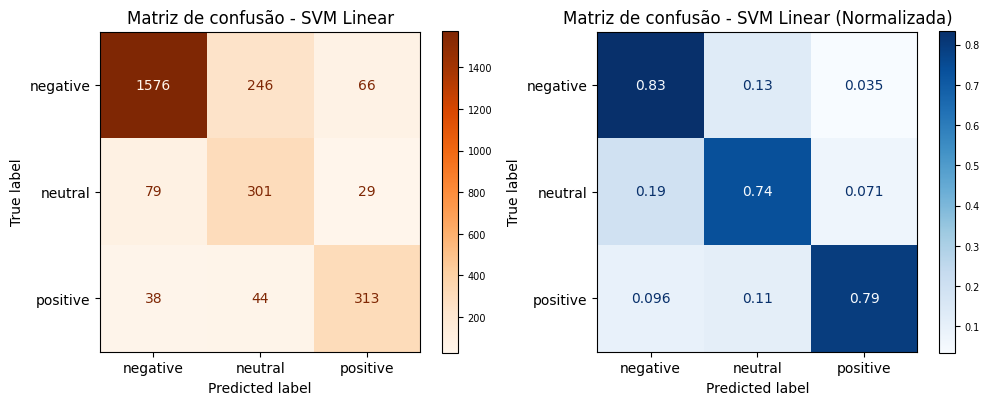



Relatório de classificação:
              precision    recall  f1-score   support

    negative       0.93      0.83      0.88      1888
     neutral       0.51      0.74      0.60       409
    positive       0.77      0.79      0.78       395

    accuracy                           0.81      2692
   macro avg       0.74      0.79      0.75      2692
weighted avg       0.84      0.81      0.82      2692


F1-score médio (macro): 0.7539258829839559


In [ ]:
plt.style.use("default")
fig, axes = plt.subplots(1, 2, figsize=(10, 5.9))

conf_matrix_linear = confusion_matrix(y_test, predict_linear)
conf_matrix_linear_norm = confusion_matrix(y_test, predict_linear, normalize= 'true') # normalize divide o valor pela soma da linha

disp_linear = ConfusionMatrixDisplay(conf_matrix_linear, display_labels= SVM_linear.classes_)
im_linear= disp_linear.plot(cmap='Oranges', ax= axes[0], colorbar= False)
axes[0].set_title("Matriz de confusão - SVM Linear")
cbar = fig.colorbar(im_linear.im_, ax=axes[0], shrink=0.8, fraction=0.045, pad=0.06)  # controlar o colorbar
cbar.ax.tick_params(labelsize=7)

disp_linear_norm= ConfusionMatrixDisplay(conf_matrix_linear_norm, display_labels= SVM_linear.classes_)
im2_linear= disp_linear_norm.plot(cmap='Blues', ax= axes[1], colorbar= False)
axes[1].set_title("Matriz de confusão - SVM Linear (Normalizada)")      #é o recal
cbar2 = fig.colorbar(im2_linear.im_, ax=axes[1], shrink=0.8, fraction=0.045, pad=0.06)
cbar2.ax.tick_params(labelsize=7)


plt.tight_layout()
plt.show()
print("\n\nRelatório de classificação:")
print(classification_report(y_test, predict_linear))
print(f"\nF1-score médio (macro): {f1_score(y_test, predict_linear, average='macro')}")

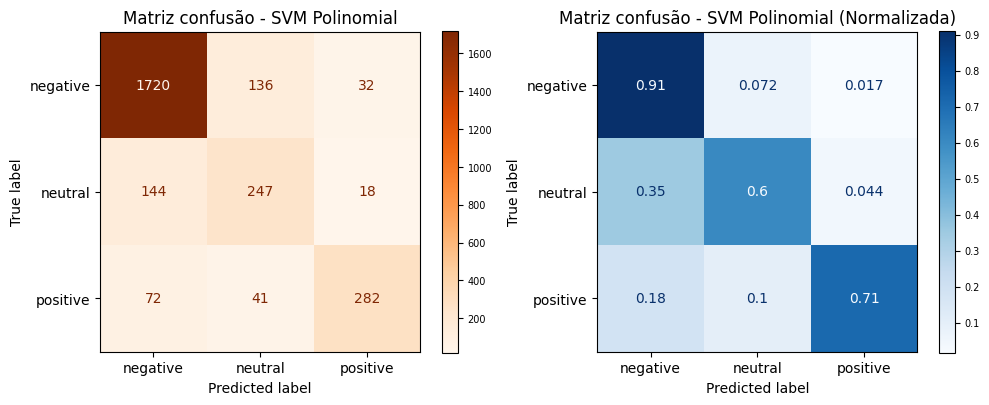



Relatório de classificação
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1888
     neutral       0.58      0.60      0.59       409
    positive       0.85      0.71      0.78       395

    accuracy                           0.84      2692
   macro avg       0.77      0.74      0.76      2692
weighted avg       0.84      0.84      0.83      2692


F1-score médio (macro): 0.7561365754799039


In [ ]:
conf_matrix_poly= confusion_matrix(y_test, predict_poly)
disp_poly= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_poly, display_labels= SVM_poly.classes_)

conf_matrix_poly_norm= confusion_matrix(y_test, predict_poly, normalize= 'true')
disp_poly_norm= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_poly_norm, display_labels= SVM_poly.classes_)


plt.style.use("default")
fig, axes= plt.subplots(1,2,figsize=(10, 5.9))
im_poly= disp_poly.plot(cmap= "Oranges", ax= axes[0], colorbar= False)
axes[0].set_title("Matriz confusão - SVM Polinomial")
cbar = fig.colorbar(im_poly.im_, ax=axes[0], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)

im2_poly= disp_poly_norm.plot(cmap= 'Blues', ax= axes[1], colorbar= False)
axes[1].set_title("Matriz confusão - SVM Polinomial (Normalizada)")
cbar = fig.colorbar(im2_poly.im_, ax=axes[1], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)


plt.tight_layout()
plt.show()
print("\n\nRelatório de classificação")
print(classification_report(y_test, predict_poly))
print(f"\nF1-score médio (macro): {f1_score(y_test, predict_poly, average='macro')}")

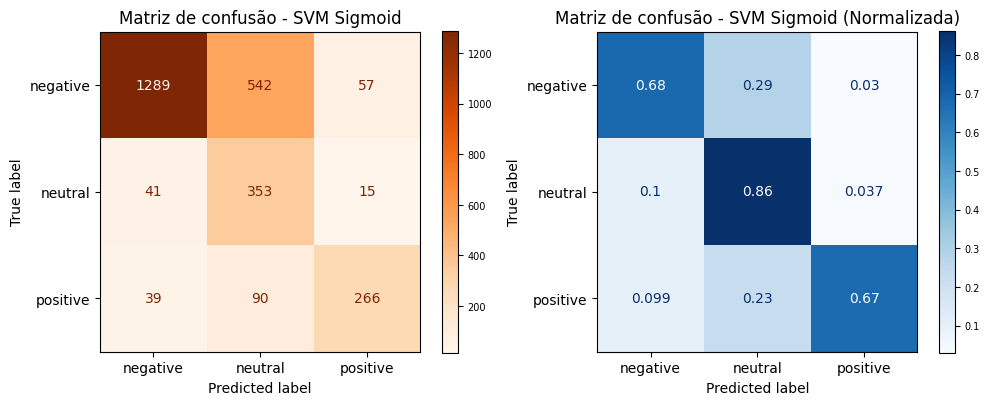



Relatório de classificação:
              precision    recall  f1-score   support

    negative       0.94      0.68      0.79      1888
     neutral       0.36      0.86      0.51       409
    positive       0.79      0.67      0.73       395

    accuracy                           0.71      2692
   macro avg       0.70      0.74      0.67      2692
weighted avg       0.83      0.71      0.74      2692


F1-score médio (macro): 0.67458887754316


In [ ]:
conf_matrix_sigmoid= confusion_matrix(y_test, predict_sigmoid)
disp_sigmoid= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_sigmoid, display_labels= SVM_sigmoid.classes_)

conf_matrix_sigmoid_norm= confusion_matrix(y_test, predict_sigmoid, normalize= "true")
disp_sigmoid_norm= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_sigmoid_norm, display_labels= SVM_sigmoid.classes_)


plt.style.use("default")
fig, axes= plt.subplots(1,2,figsize=(10, 5.9))

im_sigmoid= disp_sigmoid.plot(cmap= "Oranges", ax= axes[0], colorbar= False)
axes[0].set_title("Matriz de confusão - SVM Sigmoid")
cbar = fig.colorbar(im_sigmoid.im_, ax=axes[0], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)

im2_sigmoid= disp_sigmoid_norm.plot(cmap='Blues', ax= axes[1], colorbar= False)
axes[1].set_title("Matriz de confusão - SVM Sigmoid (Normalizada)")
cbar = fig.colorbar(im2_sigmoid.im_, ax=axes[1], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)


plt.tight_layout()
plt.show()
print("\n\nRelatório de classificação:")
print(classification_report(y_test, predict_sigmoid))
print(f"\nF1-score médio (macro): {f1_score(y_test, predict_sigmoid, average='macro')}")

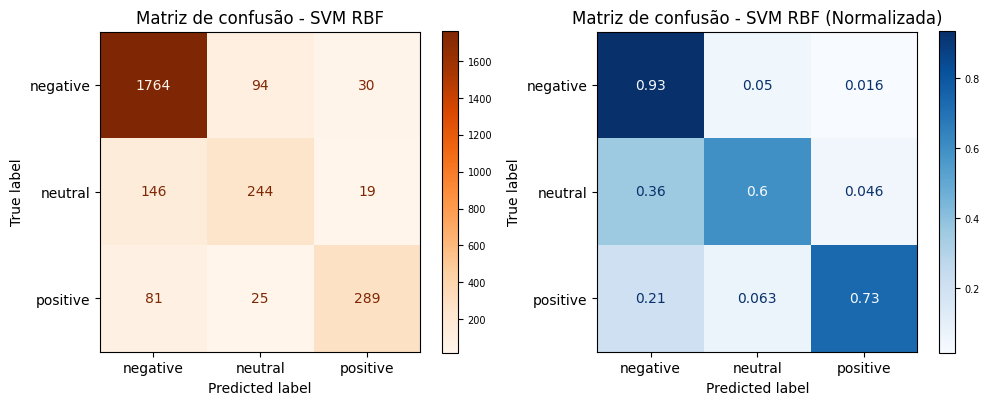



Relatório de classificação:
              precision    recall  f1-score   support

    negative       0.89      0.93      0.91      1888
     neutral       0.67      0.60      0.63       409
    positive       0.86      0.73      0.79       395

    accuracy                           0.85      2692
   macro avg       0.80      0.75      0.78      2692
weighted avg       0.85      0.85      0.85      2692


F1-score médio (macro): 0.7767257863062181


In [ ]:
conf_matrix_rbf = confusion_matrix(y_test, predict_rbf)
conf_matrix_rbf_norm = confusion_matrix(y_test, predict_rbf, normalize= 'true')


plt.style.use("default")
fig, axes = plt.subplots(1, 2, figsize=(10, 5.9))

disp_rbf = ConfusionMatrixDisplay(conf_matrix_rbf, display_labels= SVM_rbf.classes_)
im_rbf= disp_rbf.plot(cmap='Oranges', ax= axes[0], colorbar= False)
axes[0].set_title("Matriz de confusão - SVM RBF")
cbar = fig.colorbar(im_rbf.im_, ax=axes[0], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)

disp_rbf_norm = ConfusionMatrixDisplay(conf_matrix_rbf_norm, display_labels= SVM_rbf.classes_)
im2_rbf= disp_rbf_norm.plot(cmap='Blues', ax= axes[1], colorbar= False)
axes[1].set_title("Matriz de confusão - SVM RBF (Normalizada)")
cbar = fig.colorbar(im2_rbf.im_, ax=axes[1], shrink=0.8, fraction=0.045, pad=0.06)
cbar.ax.tick_params(labelsize=7)


plt.tight_layout()
plt.show()
print("\n\nRelatório de classificação:")
print(classification_report(y_test, predict_rbf))
print(f"\nF1-score médio (macro): {f1_score(y_test, predict_rbf, average='macro')}")

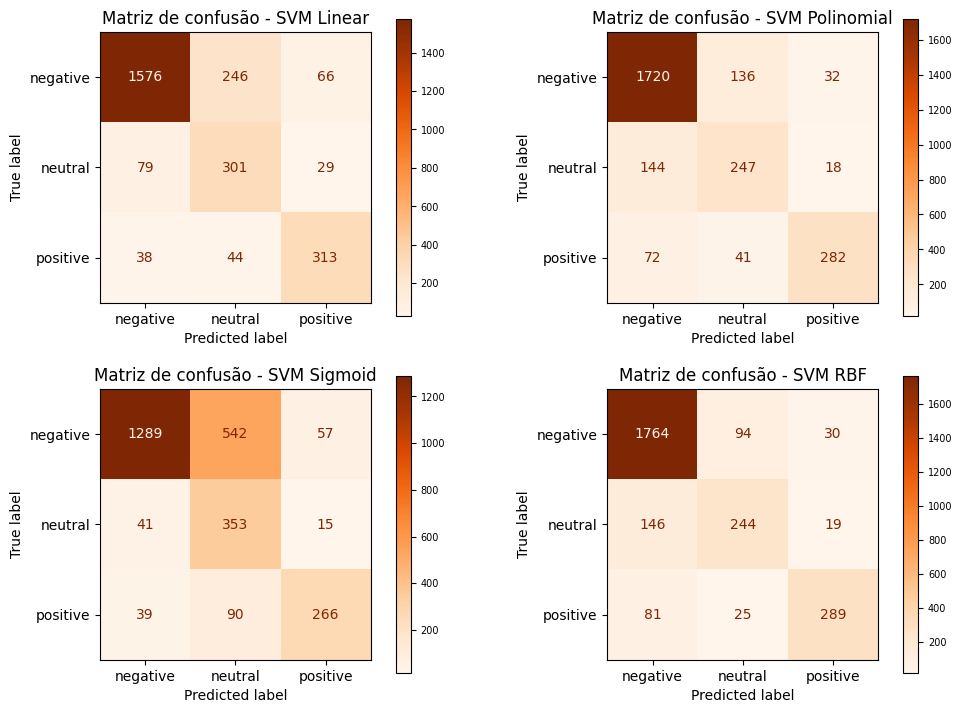

In [ ]:
plt.style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(12, 8.5))

im_linear= disp_linear.plot(cmap='Oranges', ax= axes[0][0], colorbar= False)
axes[0][0].set_title("Matriz de confusão - SVM Linear")
cbar = fig.colorbar(im_linear.im_, ax=axes[0][0], shrink=1, fraction=0.3, pad=0.06)  # controlar o colorbar
cbar.ax.tick_params(labelsize=7)


im_poly= disp_poly.plot(cmap= "Oranges", ax= axes[0][1], colorbar= False)
axes[0][1].set_title("Matriz de confusão - SVM Polinomial")
cbar = fig.colorbar(im_poly.im_, ax=axes[0][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)


im_sigmoid= disp_sigmoid.plot(cmap= "Oranges", ax= axes[1][0], colorbar= False)
axes[1][0].set_title("Matriz de confusão - SVM Sigmoid")
cbar = fig.colorbar(im_sigmoid.im_, ax=axes[1][0], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)


disp_rbf = ConfusionMatrixDisplay(conf_matrix_rbf, display_labels= SVM_rbf.classes_)
im_rbf= disp_rbf.plot(cmap='Oranges', ax= axes[1][1], colorbar= False)
axes[1][1].set_title("Matriz de confusão - SVM RBF")
cbar = fig.colorbar(im_rbf.im_, ax=axes[1][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)

/tmp/ipython-input-412829271.py:6: UserWarning: Adding colorbar to a different Figure <Figure size 1200x850 with 8 Axes> than <Figure size 1200x850 with 5 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im_linear.im_, ax=axes[0][0], shrink=1, fraction=0.3, pad=0.06)  # controlar o colorbar



Relatório do SVM Polinomial garu 3
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1888
     neutral       0.58      0.60      0.59       409
    positive       0.85      0.71      0.78       395

    accuracy                           0.84      2692
   macro avg       0.77      0.74      0.76      2692
weighted avg       0.84      0.84      0.83      2692


Relatório do SVM Polinomial grau 4
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1888
     neutral       0.59      0.61      0.60       409
    positive       0.86      0.71      0.78       395

    accuracy                           0.84      2692
   macro avg       0.78      0.74      0.76      2692
weighted avg       0.84      0.84      0.84      2692


Relatório do SVM Polinomial grau 10
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1888
     neutral       0

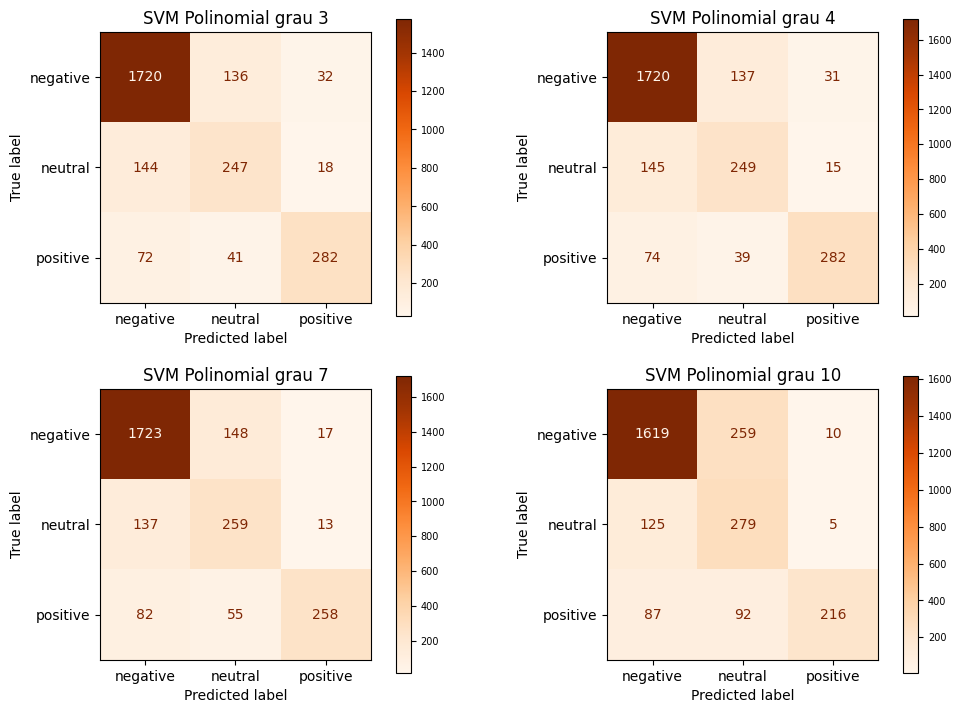

In [ ]:
plt.style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(12, 8.5))

im_poly= disp_poly.plot(cmap='Oranges', ax= axes[0][0], colorbar= False)
axes[0][0].set_title("SVM Polinomial grau 3")
cbar = fig.colorbar(im_linear.im_, ax=axes[0][0], shrink=1, fraction=0.3, pad=0.06)  # controlar o colorbar
cbar.ax.tick_params(labelsize=7)
print()
print("Relatório do SVM Polinomial garu 3")
print(classification_report(y_test, predict_poly))


conf_matrix_poly_4= confusion_matrix(y_test, predict_poly_4)
disp_poly_4= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_poly_4, display_labels= SVM_poly_4.classes_)
im_poly_4= disp_poly_4.plot(cmap= "Oranges", ax= axes[0][1], colorbar= False)
axes[0][1].set_title("SVM Polinomial grau 4")
cbar = fig.colorbar(im_poly_4.im_, ax=axes[0][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)
print()
print("Relatório do SVM Polinomial grau 4")
print(classification_report(y_test, predict_poly_4))


conf_matrix_poly_7= confusion_matrix(y_test, predict_poly_7)
disp_poly_7= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_poly_7, display_labels= SVM_poly_7.classes_)
im_poly_7= disp_poly_7.plot(cmap= "Oranges", ax= axes[1][0], colorbar= False)
axes[1][0].set_title("SVM Polinomial grau 7")
cbar = fig.colorbar(im_poly_7.im_, ax=axes[1][0], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)
print()
print("Relatório do SVM Polinomial grau 10")
print(classification_report(y_test, predict_poly_7))


conf_matrix_poly_10= confusion_matrix(y_test, predict_poly_10)
disp_poly_10= ConfusionMatrixDisplay(confusion_matrix= conf_matrix_poly_10, display_labels= SVM_poly_10.classes_)
im_poly_10= disp_poly_10.plot(cmap='Oranges', ax= axes[1][1], colorbar= False)
axes[1][1].set_title("SVM Polinomial grau 10")
cbar = fig.colorbar(im_poly_10.im_, ax=axes[1][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)
print()
print(classification_report(y_test, predict_poly_10))

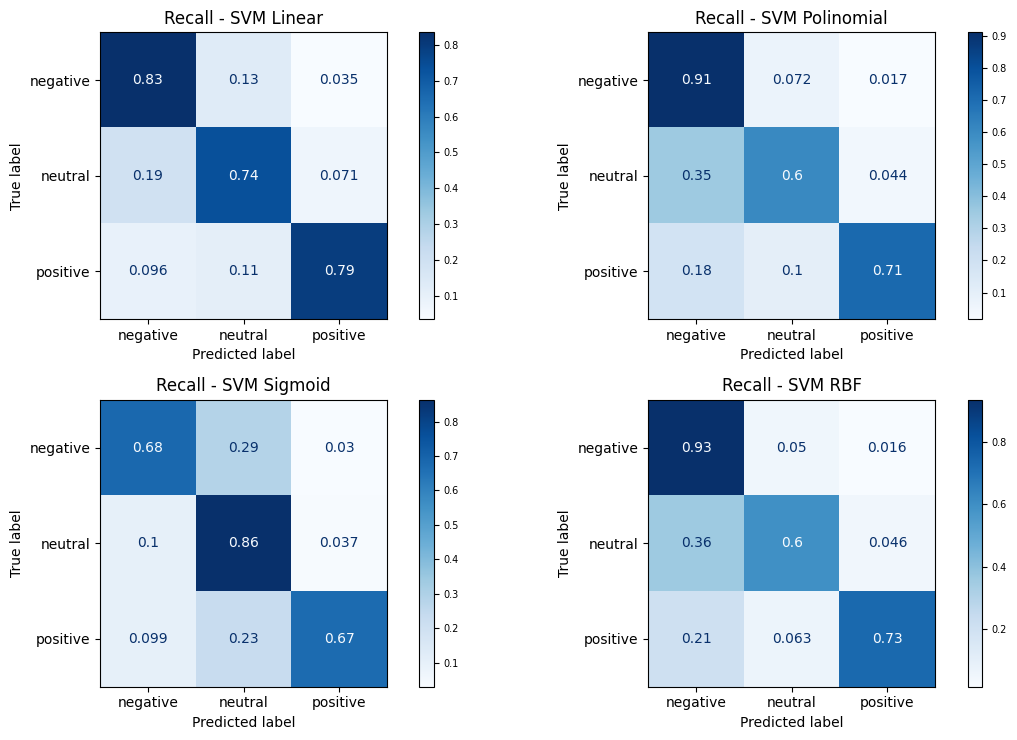

In [ ]:
plt.style.use("default")
fig, axes = plt.subplots(2, 2, figsize=(12, 7.5))

disp_linear_norm.plot(cmap='Blues', ax= axes[0][0], colorbar= False)
axes[0][0].set_title("Recall - SVM Linear")
cbar = fig.colorbar(im2_linear.im_, ax= axes[0][0], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)


disp_poly_norm.plot(cmap= 'Blues', ax= axes[0][1], colorbar= False)
axes[0][1].set_title("Recall - SVM Polinomial")
cbar = fig.colorbar(im2_poly.im_, ax=axes[0][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)


disp_sigmoid_norm.plot(cmap='Blues', ax= axes[1][0], colorbar= False)
axes[1][0].set_title("Recall - SVM Sigmoid")
cbar = fig.colorbar(im2_sigmoid.im_, ax=axes[1][0], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)


disp_rbf_norm.plot(cmap='Blues', ax= axes[1][1], colorbar= False)
axes[1][1].set_title("Recall - SVM RBF")
cbar = fig.colorbar(im2_rbf.im_, ax=axes[1][1], shrink=1, fraction=0.3, pad=0.06)
cbar.ax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()

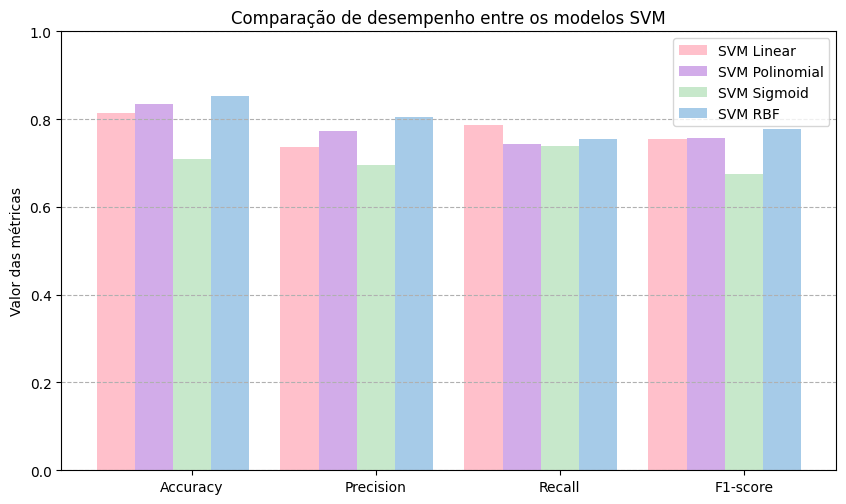

In [ ]:
def barchart(y_test, y_predict):
    return [
        accuracy_score(y_test, y_predict),
        precision_score(y_test, y_predict, average='macro'),
        recall_score(y_test, y_predict, average='macro'),
        f1_score(y_test, y_predict, average='macro')
    ]

svm_linear= barchart(y_test, predict_linear)
svm_poly= barchart(y_test, predict_poly)
svm_sigmoid= barchart(y_test, predict_sigmoid)
svm_rbf= barchart(y_test, predict_rbf)


metrics= ['Accuracy', 'Precision', 'Recall', 'F1-score']
x= np.arange(len(metrics)) * 1.35
width= 0.28  # largura das barras

plt.figure(figsize=(10,5.7))
plt.bar(x -2* width, svm_linear, width, label= 'SVM Linear', facecolor= 'Pink')
plt.bar(x - width, svm_poly, width, label= 'SVM Polinomial', color= '#D2ACE9')
plt.bar(x , svm_sigmoid, width, label= 'SVM Sigmoid', color= '#C7E8CB')
plt.bar(x + width, svm_rbf, width, label= 'SVM RBF', color= '#A6CBE8')

plt.grid(axis='y', linestyle='--', alpha= 1)
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.title('Comparação de desempenho entre os modelos SVM')
plt.ylabel('Valor das métricas')
plt.legend()
plt.show()

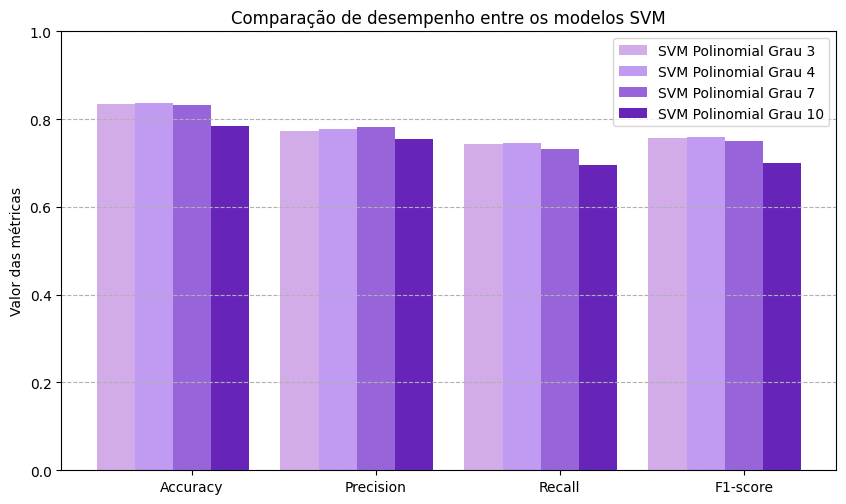

In [ ]:
svm_poly= barchart(y_test, predict_poly)
svm_poly_4= barchart(y_test, predict_poly_4)
svm_poly_7= barchart(y_test, predict_poly_7)
svm_poly_10= barchart(y_test, predict_poly_10)

plt.figure(figsize=(10,5.7))
plt.bar(x -2* width, svm_poly, width, label= 'SVM Polinomial Grau 3', facecolor= '#D2ACE9')
plt.bar(x - width, svm_poly_4, width, label= 'SVM Polinomial Grau 4', color= '#c19af2')
plt.bar(x , svm_poly_7, width, label= 'SVM Polinomial Grau 7', color= '#9864d9')
plt.bar(x + width, svm_poly_10, width, label= 'SVM Polinomial Grau 10', color= '#6624b9')

plt.grid(axis='y', linestyle='--', alpha= 1)
plt.ylim(0, 1)
plt.xticks(x, metrics)
plt.title('Comparação de desempenho entre os modelos SVM')
plt.ylabel('Valor das métricas')
plt.legend()
plt.show()